In [161]:
import sys
sys.path.append('..')
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sympy import simplify_logic

from lens.utils.relu_nn import get_reduced_model, prune_features
from lens import logic
from lens.utils.base import collect_parameters, set_seed

set_seed(0)

In [2]:
gene_expression_matrix = pd.read_csv('w_1/data_0.csv', index_col=None, header=None)
labels = pd.read_csv('w_1/tempLabels_W-1.csv', index_col=None, header=None)
genes = pd.read_csv('w_1/features_0.csv', index_col=None, header=None)

In [3]:
gene_expression_matrix

0          1         2         3         4          5         6      \
0   14.622486  11.162004  3.320000  3.320000  3.320000  12.788433  6.143456   
1   14.398743  11.000080  3.320000  3.320000  3.320000  12.845914  6.147482   
2   14.692079  11.100175  3.320000  4.171535  3.320000  12.712544  5.583210   
3   14.613382  11.023209  3.320000  3.320000  3.320000  12.750496  5.688023   
4   14.482065  10.989851  3.320000  3.992726  4.574745  12.878702  6.195418   
..        ...        ...       ...       ...       ...        ...       ...   
56  14.565031  11.699843  3.320000  3.320000  3.320000  12.789212  6.504027   
57  14.624502  11.918757  3.320000  4.292406  3.430485  10.728709  6.197159   
58  14.585190  11.090112  3.320000  3.674768  3.320000  12.877485  6.326960   
59  14.449554  10.805855  3.320000  3.320000  3.320000  12.660038  6.261395   
60  14.439020  11.080826  4.152651  3.320000  3.320000  12.187504  6.154358   

       7         8         9      ...  28392     28393     28394     28395  \
0   3.320000  4.876620  3.320000  ...   3.32  3.320000  3.885589  3.914260   
1   3.320000  4.484223  3.320000  ...   3.32  3.575025  4.236519  4.047825   
2   3.320000  3.478171  3.320000  ...   3.32  3.320000  3.992331  4.865538   
3   3.320000  4.464426  3.320000  ...   3.32  3.855643  3.320000  4.905350   
4   4.177962  3.872567  3.320000  ...   3.32  3.320000  3.320000  4.879493   
..       ...       ...       ...  ...    ...       ...       ...       ...   
56  3.320000  3.320000  6.182912  ...   3.32  3.320000  3.320000  4.338456   
57  3.320000  4.089918  5.201608  ...   3.32  3.320000  3.320000  4.790134   
58  3.320000  3.320000  3.320000  ...   3.32  3.320000  3.320000  4.547342   
59  3.320000  4.125096  3.320000  ...   3.32  3.784260  3.644823  4.546974   
60  3.320000  4.247009  3.320000  ...   3.32  3.671102  3.519157  4.771458   

       28396  28397     28398     28399     28400     28401  
0   3.320000   3.32  3.320000  4.465420  3.320000  4.973620  
1   3.320000   3.32  4.176269  3.320000  4.553796  4.967418  
2   3.320000   3.32  3.488281  3.406285  3.320000  6.676063  
3   3.320000   3.32  4.158393  4.433457  3.874214  5.981160  
4   3.320000   3.32  4.571869  3.320000  4.982136  6.145585  
..       ...    ...       ...       ...       ...       ...  
56  3.771718   3.32  3.320000  3.320000  3.320000  6.100644  
57  3.320000   3.32  4.985474  4.444057  3.580523  6.301926  
58  3.320000   3.32  4.064473  3.320000  4.254152  5.964505  
59  3.427441   3.32  4.666265  3.888525  3.765754  5.452018  
60  3.320000   3.32  5.115644  3.320000  3.410361  6.449961  

[61 rows x 28402 columns]

In [4]:
labels

0
0               diagnosis: healthy control
1               diagnosis: healthy control
2               diagnosis: healthy control
3               diagnosis: healthy control
4               diagnosis: healthy control
..                                     ...
56  omalizumab responder status: Responder
57  omalizumab responder status: Responder
58  omalizumab responder status: Responder
59  omalizumab responder status: Responder
60  omalizumab responder status: Responder

[61 rows x 1 columns]

In [5]:
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels.values)
labels_encoded_noncontrols = labels_encoded[labels_encoded!=0] - 1

data_controls = gene_expression_matrix[labels_encoded==0]
data = gene_expression_matrix[labels_encoded!=0]

gene_signature = data_controls.mean(axis=0)
data_scaled = data - gene_signature

scaler = MinMaxScaler((0, 1))
scaler.fit(data_scaled)
data_normalized = scaler.transform(data_scaled)

x = torch.FloatTensor(data_normalized)
y = torch.FloatTensor(labels_encoded_noncontrols).unsqueeze(1)
print(x.shape)
print(y.shape)

c:\users\pietr\anaconda3\envs\deep-logic\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


torch.Size([40, 28402])
torch.Size([40, 1])


In [42]:
set_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
y = y.to(device)

layers = [
    torch.nn.Linear(x.size(1), 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
need_pruning = True
for epoch in range(15000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x)
    # Compute Loss
    loss = torch.nn.functional.mse_loss(y_pred, y)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.01 * torch.norm(module.weight, 1)
            loss += 0.01 * torch.norm(module.bias, 1)

    # backward pass
    loss.backward()
    optimizer.step()

    # compute accuracy
    if epoch % 1000 == 0:
        y_pred_d = (y_pred > 0.5)
        accuracy = (y_pred_d.eq(y).sum(dim=1) == y.size(1)).sum().item() / y.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')
        
    if epoch > 8000 and need_pruning and epoch % 1000 == 0:
        prune_features(model, 1, device)
        need_pruning = True

Epoch 0: train accuracy: 0.2250
Epoch 1000: train accuracy: 0.7500
Epoch 2000: train accuracy: 0.7500
Epoch 3000: train accuracy: 0.7500
Epoch 4000: train accuracy: 0.9500
Epoch 5000: train accuracy: 0.9750
Epoch 6000: train accuracy: 1.0000
Epoch 7000: train accuracy: 1.0000
Epoch 8000: train accuracy: 1.0000
Epoch 9000: train accuracy: 1.0000
Epoch 10000: train accuracy: 1.0000
Epoch 11000: train accuracy: 1.0000
Epoch 12000: train accuracy: 1.0000
Epoch 13000: train accuracy: 1.0000
Epoch 14000: train accuracy: 1.0000


## Local explanations

In [43]:
np.set_printoptions(precision=2, suppress=True)
outputs = []
for i, (xin, yin) in enumerate(zip(x, y)):
    model_reduced = get_reduced_model(model, xin.to(device)).to(device)
    for module in model_reduced.children():
        if isinstance(module, torch.nn.Linear):
            wa = module.weight.cpu().detach().numpy()
            break
    output = model_reduced(xin)
    
    pred_class = torch.argmax(output)
    true_class = torch.argmax(y[i])

    # generate local explanation only if the prediction is correct
    if pred_class.eq(true_class):
        local_explanation = logic.relu_nn.explain_local(model.to(device), x, y, xin, yin, device=device)
        print(f'Input {(i+1)}')
        print(f'\tx={xin.cpu().detach().numpy()}')
        print(f'\ty={y[i].cpu().detach().numpy()}')
        print(f'\ty={output.cpu().detach().numpy()}')
        #print(f'\tw={wa}')
        print(f'\tExplanation: {local_explanation}')
        print()
    outputs.append(output)

Input 1
	x=[0.94 0.31 0.   ... 0.26 0.8  0.68]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & feature0000013710 & feature0000022010 & ~feature0000025379 & ~feature0000026329

Input 2
	x=[0.84 0.71 0.   ... 0.26 0.   0.62]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000026329

Input 3
	x=[0.62 0.36 0.   ... 0.   0.   0.71]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & ~feature0000013710 & ~feature0000022010 & ~feature0000025379 & feature0000026329

Input 4
	x=[0.81 0.95 0.   ... 0.83 0.   0.95]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & feature0000013710 & ~feature0000026329

Input 5
	x=[0.   0.68 0.   ... 0.43 0.   0.89]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & ~feature0000013710 & ~feature0000022010 & ~feature0000025379 & ~feature0000026329

Input 6
	x=[0.79 0.65 0.   ... 0.3  0.   0.69]
	y=[0.]
	y=[0.99]
	Explanation: 

Input 7


# Combine local explanations

In [44]:
dummy_names = [f'g{i}' for i in range(x.shape[1])]

In [45]:
concept_names = genes.values.squeeze()
concept_names

array(['ILMN_1343291', 'ILMN_1343295', 'ILMN_1651199', ...,
       'ILMN_3311165', 'ILMN_3311180', 'ILMN_3311190'], dtype=object)

In [46]:
from sklearn.preprocessing import OneHotEncoder
y1h = OneHotEncoder(sparse=False).fit_transform(y.cpu().detach().numpy())
y2 = torch.FloatTensor(y1h).to(device)

In [48]:
global_explanation, predictions, counter = logic.combine_local_explanations(model, 
                                                                          x=x, y=y, method='pruning', 
                                                                          target_class=0,
                                                                          topk_explanations=8,
                                                                          device=device)

accuracy, preds = logic.base.test_explanation(global_explanation, 0, x, y)
final_formula = logic.base.replace_names(global_explanation, concept_names)
final_formula_with_dummies = logic.base.replace_names(global_explanation, dummy_names)
print(f'Accuracy of when using the formula "{final_formula}": {accuracy:.4f}\n')
print(f'Accuracy of when using the formula "{final_formula_with_dummies}": {accuracy:.4f}')

Accuracy of when using the formula "(~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_1777811 & ~ILMN_2241168 & ~ILMN_3228700) | (ILMN_1777811 & ILMN_2241168 & ~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_3228700 & ~ILMN_3243714) | (ILMN_3243714 & ~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_1775520 & ~ILMN_1777811 & ~ILMN_3228700)": 0.9750

Accuracy of when using the formula "(~g6749 & ~g10382 & ~g13710 & ~g22010 & ~g25379) | (g13710 & g22010 & ~g6749 & ~g10382 & ~g25379 & ~g26329) | (g26329 & ~g6749 & ~g10382 & ~g13464 & ~g13710 & ~g25379)": 0.9750


In [52]:
global_explanation, predictions, counter = logic.combine_local_explanations(model, 
                                                                          x=x, y=y, method='pruning', 
                                                                          target_class=1,
                                                                          topk_explanations=10,
                                                                          device=device)

accuracy, preds = logic.base.test_explanation(global_explanation, 1, x, y)
final_formula = logic.base.replace_names(global_explanation, concept_names)
final_formula_with_dummies = logic.base.replace_names(global_explanation, dummy_names)
print(f'Accuracy of when using the formula "{final_formula}": {accuracy:.4f}\n')
print(f'Accuracy of when using the formula "{final_formula_with_dummies}": {accuracy:.4f}')

Accuracy of when using the formula "(ILMN_1708983 & ILMN_1745049 & ~ILMN_1775520) | (ILMN_1777811 & ILMN_3228700 & ~ILMN_2241168) | (ILMN_1745049 & ILMN_1777811 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1745049 & ILMN_3228700 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1745049 & ILMN_3243714 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1777811 & ILMN_3243714 & ~ILMN_1708983 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1708983 & ILMN_3243714 & ~ILMN_1775520 & ~ILMN_1777811 & ~ILMN_2241168 & ~ILMN_3228700)": 0.9000

Accuracy of when using the formula "(g6749 & g10382 & ~g13464) | (g13710 & g25379 & ~g22010) | (g10382 & g13710 & ~g13464 & ~g22010) | (g10382 & g25379 & ~g13464 & ~g22010) | (g10382 & g26329 & ~g13464 & ~g22010) | (g13710 & g26329 & ~g6749 & ~g13464 & ~g22010) | (g6749 & g26329 & ~g13464 & ~g13710 & ~g22010 & ~g25379)": 0.9000


In [13]:
w, b = collect_parameters(model, device)
feature_weights = w[0]
feature_used_bool = np.sum(np.abs(feature_weights), axis=0) > 0
feature_used = np.nonzero(feature_used_bool)[0]
genes.iloc[feature_used]

0
6749   ILMN_1708983
10382  ILMN_1745049
13464  ILMN_1775520
13710  ILMN_1777811
22010  ILMN_2241168
25379  ILMN_3228700
26329  ILMN_3243714

In [14]:
global_explanation2 = logic.relu_nn.explain_global(model, n_classes=1, target_class=0, device=device)
explanation = logic.relu_nn.explain_global(model, n_classes=1, target_class=0, device=device)
if explanation not in ['False', 'True', 'The formula is too complex!']:
    accuracy, _ = logic.relu_nn.test_explanation(explanation, target_class=0, x=x.cpu(), y=y.cpu())
    print(f'Class {0} - Global explanation: "{global_explanation2}" - Accuracy: {accuracy:.4f}')

Class 0 - Global explanation: "(feature0000006749 & feature0000010382 & feature0000013710) | (feature0000006749 & feature0000010382 & feature0000025379) | (feature0000006749 & feature0000010382 & feature0000026329) | (feature0000006749 & feature0000013710 & feature0000025379) | (feature0000006749 & feature0000013710 & feature0000026329) | (feature0000006749 & feature0000025379 & feature0000026329) | (feature0000010382 & feature0000013710 & feature0000025379) | (feature0000010382 & feature0000013710 & feature0000026329) | (feature0000010382 & feature0000025379 & feature0000026329) | (feature0000013710 & feature0000025379 & feature0000026329) | (feature0000006749 & feature0000010382 & ~feature0000013464) | (feature0000006749 & feature0000010382 & ~feature0000022010) | (feature0000006749 & feature0000013710 & ~feature0000013464) | (feature0000006749 & feature0000013710 & ~feature0000022010) | (feature0000006749 & feature0000025379 & ~feature0000022010) | (feature0000006749 & feature000002

## From previous works

ILMN_3286286, **ILMN_1775520**, ILMN_1656849, ILMN_1781198, ILMN_1665457

# Cross validation

In [170]:
import copy
def train_nn(x_train, y_train, layers, device):
    set_seed(0)
    layers = [
        torch.nn.Linear(x_train.size(1), 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
        torch.nn.Sigmoid(),
    ]
    model = torch.nn.Sequential(*layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train()
    need_pruning = True
    for epoch in range(20000):
        # forward pass
        optimizer.zero_grad()
        y_pred = model(x_train)
        # Compute Loss
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_train)

        for module in model.children():
            if isinstance(module, torch.nn.Linear):
                loss += 0.05 * torch.norm(module.weight, 1)
                loss += 0.05 * torch.norm(module.bias, 1)
            break

        # backward pass
        loss.backward()
        optimizer.step()

        if epoch > 10000 and need_pruning and epoch % 1000 == 0:
            prune_features(model, 1, device)
            need_pruning = True
    
        # compute accuracy
        if epoch % 1000 == 0:
            y_pred_d = (y_pred > 0.5)
            accuracy = (y_pred_d.eq(y_train).sum(dim=1) == y_train.size(1)).sum().item() / y_train.size(0)
            print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')

    global_explanation, predictions, counter = logic.combine_local_explanations(model, 
                                                                              x=x_train, y=y_train, 
                                                                              method='pruning', 
                                                                              target_class=0,
                                                                              topk_explanations=30,
                                                                              device=device)
#     global_explanation2, predictions, counter = logic.combine_local_explanations(model, 
#                                                                               x=x_train, y=y_train, 
#                                                                               method='pruning', 
#                                                                               target_class=1,
#                                                                               topk_explanations=30,
#                                                                               device=device)

    return model, global_explanation#, global_explanation2

In [171]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

explanations = []
model_accuracies = []
formula_accuracies = []
for i, (train_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(), y.cpu().detach().numpy())):
    print(f'Split [{i+1}/{n_splits}]')
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model, explanation = train_nn(x_train, y_train, layers, device)
    explanations.append(explanation)
    
    y_preds = (model(x_test) > 0.5).cpu().detach().numpy()
    accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds)
    print(f'\t Accuracy: {accuracy:.4f}')
    model_accuracies.append(accuracy)
    
    accuracy, preds = logic.base.test_explanation(explanation, 0, x_test, y_test)
    final_formula = logic.base.replace_names(explanation, concept_names)
    print(f'\t Formula: "{final_formula}" \n\t Test accuracy (formula): {accuracy*100:.2f}%\n')
    formula_accuracies.append(accuracy)
    
#     accuracy, preds = logic.base.test_explanation(explanation, 1, x_test, y_test)
#     final_formula = logic.base.replace_names(explanation, concept_names)
#     print(f'\t Formula 2: "{final_formula}" \n\t Test accuracy (formula): {accuracy*100:.2f}%\n')

Split [1/5]
Epoch 0: train accuracy: 0.2500
Epoch 1000: train accuracy: 0.7500
Epoch 2000: train accuracy: 0.9062
Epoch 3000: train accuracy: 1.0000
Epoch 4000: train accuracy: 1.0000
Epoch 5000: train accuracy: 1.0000
Epoch 6000: train accuracy: 1.0000
Epoch 7000: train accuracy: 1.0000
Epoch 8000: train accuracy: 1.0000
Epoch 9000: train accuracy: 1.0000
Epoch 10000: train accuracy: 1.0000
Epoch 11000: train accuracy: 1.0000
Epoch 12000: train accuracy: 1.0000
Epoch 13000: train accuracy: 1.0000
Epoch 14000: train accuracy: 1.0000
Epoch 15000: train accuracy: 1.0000
Epoch 16000: train accuracy: 1.0000
Epoch 17000: train accuracy: 1.0000
Epoch 18000: train accuracy: 1.0000
Epoch 19000: train accuracy: 1.0000
	 Accuracy: 0.7500
	 Formula: "(ILMN_1713875 & ILMN_1775520) | (ILMN_1713875 & ILMN_1823468) | (ILMN_1775520 & ILMN_1823468)" 
	 Test accuracy (formula): 75.00%

Split [2/5]
Epoch 0: train accuracy: 0.2500
Epoch 1000: train accuracy: 0.7500
Epoch 2000: train accuracy: 0.7500
Epoch

In [172]:
model_accuracies = np.array(model_accuracies)
formula_accuracies = np.array(formula_accuracies)
print(f'Model accuracy: {model_accuracies.mean():.4f} +- {model_accuracies.std():.4f}')
print(f'Formula accuracy: {formula_accuracies.mean():.4f} +- {formula_accuracies.std():.4f}')

Model accuracy: 0.7000 +- 0.1275
Formula accuracy: 0.7500 +- 0.0791


In [136]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
classifier = DecisionTreeClassifier(random_state=0)

classifier_accuracies = []
for i, (train_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(), y.cpu().detach().numpy())):
    print(f'Split [{i+1}/{n_splits}]')
    x_train, x_test = x[train_index].cpu().detach().numpy(), x[test_index].cpu().detach().numpy()
    y_train, y_test = y[train_index].cpu().detach().numpy().squeeze(), y[test_index].cpu().detach().numpy().squeeze()
    
    classifier.fit(x_train, y_train)
    y_preds = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(f'\tAccuracy: {accuracy:.4f}')
    classifier_accuracies.append(accuracy)

classifier_accuracies = np.array(classifier_accuracies)
print(f'Model accuracy: {classifier_accuracies.mean():.4f} +- {classifier_accuracies.std():.4f}')

Split [1/5]
	Accuracy: 0.6250
Split [2/5]
	Accuracy: 0.5000
Split [3/5]
	Accuracy: 0.7500
Split [4/5]
	Accuracy: 0.8750
Split [5/5]
	Accuracy: 0.5000
Model accuracy: 0.6500 +- 0.1458


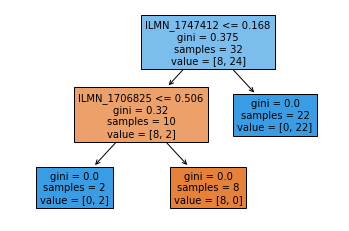

In [159]:
plot_tree(classifier, feature_names=concept_names, filled=True)
plt.show()

In [162]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
classifier = RandomForestClassifier(random_state=0)

classifier_accuracies = []
for i, (train_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(), y.cpu().detach().numpy())):
    print(f'Split [{i+1}/{n_splits}]')
    x_train, x_test = x[train_index].cpu().detach().numpy(), x[test_index].cpu().detach().numpy()
    y_train, y_test = y[train_index].cpu().detach().numpy().squeeze(), y[test_index].cpu().detach().numpy().squeeze()
    
    classifier.fit(x_train, y_train)
    y_preds = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(f'\tAccuracy: {accuracy:.4f}')
    classifier_accuracies.append(accuracy)

classifier_accuracies = np.array(classifier_accuracies)
print(f'Model accuracy: {classifier_accuracies.mean():.4f} +- {classifier_accuracies.std():.4f}')

Split [1/5]
	Accuracy: 0.8750
Split [2/5]
	Accuracy: 0.7500
Split [3/5]
	Accuracy: 0.7500
Split [4/5]
	Accuracy: 0.7500
Split [5/5]
	Accuracy: 0.7500
Model accuracy: 0.7750 +- 0.0500
